In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.optimize import newton

from numpy import linalg as LA

In [2]:
selected_info_df = pd.read_excel('data.xlsx', sheet_name='Info')
dirty_price_df = pd.read_excel('data.xlsx', sheet_name='Close Price')

# short_info, long_info = info_df.iloc[:24], info_df.iloc[24:]
# short_price, long_price = price_df.iloc[:24], price_df.iloc[24:]

In [3]:
selected_isin = ['CA135087J546', 'CA135087J967', 'CA135087K528', 'CA135087K940', 'CA135087L518',
                 'CA135087L930', 'CA135087M847', 'CA135087N837', 'CA135087P576', 'CA135087Q491', 'CA135087Q988']

selected_info_df = selected_info_df[selected_info_df['ISIN'].isin(selected_isin)].set_index('ISIN')
selected_price_df = dirty_price_df[dirty_price_df['ISIN'].isin(selected_isin)].set_index('ISIN')

##### Question 4a

In [4]:
def calculate_dirty_price(selected_info_df, selected_price_df):
    coupon_rates = selected_info_df['Coupon']

    last_coupon_date = pd.to_datetime('2023-09-01')
    days_since_last_coupon = (selected_price_df.columns.to_series() - last_coupon_date).dt.days

    dirty_price_df = pd.DataFrame(index=selected_price_df.index, columns=selected_price_df.columns)

    for current_date in selected_price_df.columns:
        n = days_since_last_coupon[current_date]
        accrued_interests = n / 365 * coupon_rates * 100
        dirty_price_df[current_date] = selected_price_df[current_date] + accrued_interests
    
    return dirty_price_df

def calculate_ytm(selected_info_df, dirty_price_df):

    def solve(t, cash_flows, coupon_rate, dirty_price):
        initial_guess = coupon_rate

        def ytm_formula(ytm):
            pv = np.sum(cash_flows*np.exp(-ytm*t))
            return pv - dirty_price

        solution = newton(ytm_formula, initial_guess)
        return solution

    def compute_ytm(current_date, maturity_date, dirty_price, coupon_rate):        
        coupon_dates = pd.date_range(start=pd.Timestamp('2024-03-01'), end=maturity_date, freq='6MS')
        t = np.array((coupon_dates - current_date).days / 365)

        cash_flows = [coupon_rate / 2 * 100] * len(t)
        cash_flows[-1] += 100
        cash_flows = np.array(cash_flows)

        ytm = solve(t, cash_flows, coupon_rate, dirty_price)
        return t, ytm

    ytm_df = pd.DataFrame(index=dirty_price_df.index, columns=dirty_price_df.columns)

    for bond in dirty_price_df.index:
        ytms = []

        coupon_rate = selected_info_df.loc[bond]['Coupon']
        maturity_date = selected_info_df.loc[bond]['Maturity Date']
        dirty_prices = dirty_price_df.loc[bond].values
        
        for current_date in dirty_price_df.columns:
            dirty_price = dirty_prices[dirty_price_df.columns.get_loc(current_date)]
            t, ytm = compute_ytm(current_date, maturity_date, dirty_price, coupon_rate)
            ytms.append(ytm)
        ytm_df.loc[bond] = ytms
        
    return t, ytm_df

In [5]:
dirty_price_df = calculate_dirty_price(selected_info_df, selected_price_df)
t, ytm_df = calculate_ytm(selected_info_df, dirty_price_df)

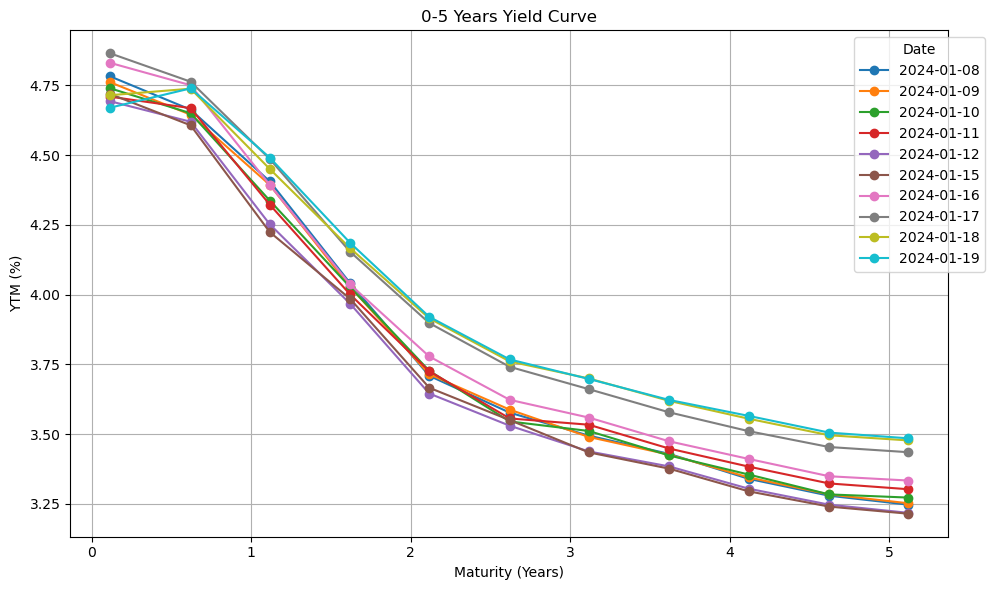

In [6]:
plt.figure(figsize=(10, 6))

for current_date in ytm_df.columns:
    plt.plot(t, ytm_df[current_date] * 100, marker='o', label=current_date.strftime('%Y-%m-%d'))

plt.title('0-5 Years Yield Curve')
plt.xlabel('Maturity (Years)')
plt.ylabel('YTM (%)')
plt.legend(title='Date', bbox_to_anchor=(1.05, 1), loc='best')
plt.grid(True)
plt.tight_layout()

plt.show()

##### Question 4b

In [7]:
def calculate_spot(selected_info_df, dirty_price_df):

    def compute_spot(known_spot_dict, coupon_rate, current_date, maturity_date, dirty_price):
        coupon_dates = pd.date_range(start=pd.Timestamp('2024-03-01'), end=maturity_date, freq='6MS')
        t = np.array((coupon_dates - current_date).days / 365)

        cash_flows = [coupon_rate / 2 * 100] * len(t)
        cash_flows[-1] += 100
        cash_flows = np.array(cash_flows)

        # Maturing in less than 6 months
        if len(t) <= 1:
            spot = -np.log(dirty_price/cash_flows[0])/t[0]
            known_spot_dict[bond] += [spot]

        # Recursively obtain spot rates using the previous known rates
        else:
            # obtain known spot rates vertically 
            current_date_idx = dirty_price_df.columns.get_loc(current_date)
            known_spots = [known_rates[current_date_idx] for known_rates in known_spot_dict.values() if len(known_rates) > current_date_idx]
            known_spots = np.array(known_spots)

            t_up_to_last, cash_flows_up_to_last = t[:-1], cash_flows[:-1]
            
            discounted_cash_flows = np.sum(cash_flows_up_to_last*np.exp(-known_spots*t_up_to_last))

            # now, solve for the spot rate
            spot = -np.log((dirty_price - discounted_cash_flows)/cash_flows[-1])/t[-1]
            known_spot_dict[bond] += [spot]

        return known_spot_dict, t, spot

    spot_df = pd.DataFrame(index=dirty_price_df.index , columns=dirty_price_df.columns)

    known_spot_dict = {bond: [] for bond in dirty_price_df.index}

    for bond in dirty_price_df.index:
        coupon_rate = selected_info_df.loc[bond]['Coupon']
        maturity_date = selected_info_df.loc[bond]['Maturity Date']
        dirty_prices = dirty_price_df.loc[bond].values
        
        spots = []
        for current_date in dirty_price_df.columns:
            dirty_price = dirty_prices[dirty_price_df.columns.get_loc(current_date)]
            known_spot_dict, t, spot = compute_spot(known_spot_dict, coupon_rate, current_date, maturity_date, dirty_price)
            spots.append(spot)
        spot_df.loc[bond] = spots

    return t, spot_df

In [8]:
t, spot_df = calculate_spot(selected_info_df, dirty_price_df)

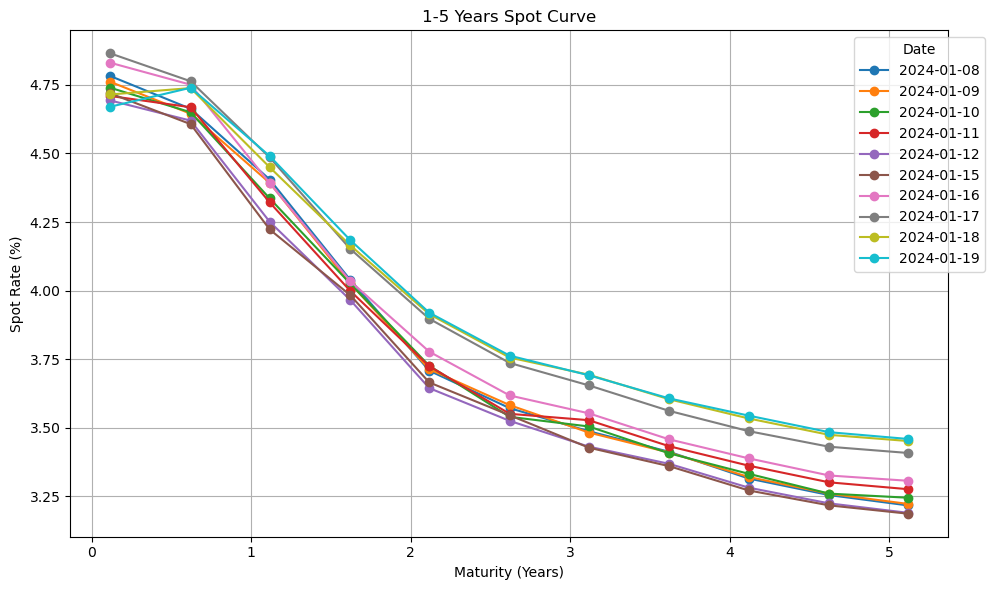

In [9]:
plt.figure(figsize=(10, 6))

for current_date in spot_df.columns:
    plt.plot(t, spot_df[current_date] * 100, marker='o', label=current_date.strftime('%Y-%m-%d'))

plt.title('1-5 Years Spot Curve')
plt.xlabel('Maturity (Years)')
plt.ylabel('Spot Rate (%)')
plt.legend(title='Date', bbox_to_anchor=(1.05, 1), loc='best')
plt.grid(True)
plt.tight_layout()

plt.show()

##### Question 4c

In [10]:
def calculate_forward(selected_info_df, spot_df):
    # 1. get t (in years) until the maturity for each bond for every date
    maturity_df = pd.DataFrame(index=spot_df.index, columns=spot_df.columns)

    for bond in spot_df.index:
        maturity_date = selected_info_df.loc[bond]['Maturity Date']
        maturity_dates = []
        for current_date in spot_df.columns:
            maturity_dates.append((maturity_date - current_date).days / 365)
        maturity_df.loc[bond] = maturity_dates

    # 2. linear interpolation of spot rates for simplitcity (i.e. t = 1, 2, 3, 4, 5)
    df_index = [f'Y{year}' for year in range(1, 6)]
    interpolation_index = {t: [int(2*t)-1, int(2*t)] for t in range(1, 6)}

    interpolated_spot_df = pd.DataFrame(index=df_index, columns=spot_df.columns)
    
    for current_date in spot_df.columns:
        interpolated_spots = []
        
        for k, v in interpolation_index.items():
            idx1, idx2 = v[0], v[1]
            spot1, spot2 = spot_df[current_date].values[idx1], spot_df[current_date].values[idx2]
            t1, t2 = maturity_df[current_date].values[idx1], maturity_df[current_date].values[idx2]
            interpolated_spot = spot1 + (k-t1) * (spot2-spot1) / (t2-t1)
            interpolated_spots.append(interpolated_spot)
            
        interpolated_spot_df[current_date] = interpolated_spots

    # 3. compute forward rates (using vectorization)
    spots1, spots2 = interpolated_spot_df.values[:-1, :], interpolated_spot_df.values[1:, :]
    ts1 = np.tile(np.arange(1, 5)[:, np.newaxis], (1, len(interpolated_spot_df.columns)))
    ts2 = np.tile(np.arange(2, 6)[:, np.newaxis], (1, len(interpolated_spot_df.columns)))

    fwds = (spots2*ts2-spots1*ts1) / (ts2-ts1)

    fwd_df = pd.DataFrame(fwds, index=df_index[1:], columns=spot_df.columns)

    return fwd_df

In [11]:
forward_df = calculate_forward(selected_info_df, spot_df)

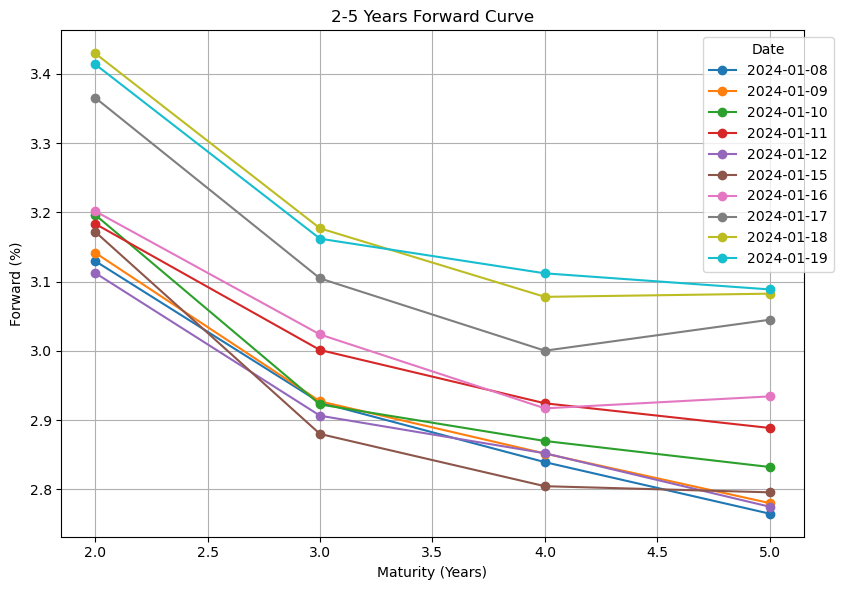

In [12]:
plt.figure(figsize=(10, 6))

t = [2, 3, 4, 5]
for current_date in forward_df.columns:
    plt.plot(t, forward_df[current_date] * 100, marker='o', label=current_date.strftime('%Y-%m-%d'))

plt.title('2-5 Years Forward Curve')
plt.xlabel('Maturity (Years)')
plt.ylabel('Forward (%)')
plt.legend(title='Date', bbox_to_anchor=(1.05, 1), loc='best')
plt.grid(True)
plt.tight_layout()

plt.show()

##### Question 5

In [13]:
def calculate_covariance_matrix(rate_type, df, isin_list):
    if rate_type == 'ytm':
        df = df.loc[isin_list].T.astype(float)
        log_returns_df = np.log(df/df.shift(1)).iloc[1:, :] # drop na
    elif rate_type == 'forward':
        df = df.T.astype(float)
        log_returns_df = np.log(df/df.shift(1)).iloc[1:, :] # drop na

    return log_returns_df.cov()

In [14]:
ytm_cov = calculate_covariance_matrix("ytm", ytm_df, selected_isin[:5])
forward_cov = calculate_covariance_matrix("forward", forward_df, selected_isin)

In [15]:
ytm_cov

ISIN,CA135087J546,CA135087J967,CA135087K528,CA135087K940,CA135087L518
ISIN,,,,,
CA135087J546,0.000216,0.000119,0.000174,0.000071,0.000126
CA135087J967,0.000119,0.000137,0.000181,0.000057,0.000137
CA135087K528,0.000174,0.000181,0.000323,0.000148,0.000246
CA135087K940,0.000071,0.000057,0.000148,0.000128,0.000161
CA135087L518,0.000126,0.000137,0.000246,0.000161,0.000260


In [16]:
forward_cov

,Y2,Y3,Y4,Y5
Y2,0.000414,0.000237,0.000201,0.000345
Y3,0.000237,0.000596,0.000481,0.000546
Y4,0.000201,0.000481,0.000437,0.000443
Y5,0.000345,0.000546,0.000443,0.000617


##### Question 6

In [17]:
ytm_eig_values, ytm_eig_vectors = LA.eig(ytm_cov.values)
ytm_eig_values, ytm_eig_vectors

(array([8.28204367e-04, 1.37750242e-04, 6.56446624e-05, 3.93445094e-06,
        2.79117675e-05]),
 array([[-0.38251518, -0.73588698, -0.55360952,  0.07270654,  0.0195638 ],
        [-0.35162114, -0.2636125 ,  0.53370739, -0.57272863,  0.44046494],
        [-0.60232019,  0.01574361,  0.40480925,  0.24569556, -0.6424373 ],
        [-0.31355612,  0.45087148, -0.47569596, -0.64351655, -0.24082623],
        [-0.51859199,  0.43063424, -0.1360726 ,  0.43842424,  0.57869243]]))

In [18]:
forward_eig_values, forward_eig_vectors = LA.eig(forward_cov.values)
forward_eig_values, forward_eig_vectors

(array([1.70195297e-03, 2.84499966e-04, 5.50626770e-05, 2.27200293e-05]),
 array([[ 0.33508372,  0.87273571,  0.32168295, -0.15023771],
        [ 0.56674617, -0.36071515,  0.04290752, -0.73948787],
        [ 0.47363411, -0.31254856,  0.61190643,  0.55095793],
        [ 0.58496873,  0.10261756, -0.72128326,  0.35641504]]))